In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from chronos import ChronosPipeline

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\envs\book-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    "#000072", # blue (for historical data)
    "#80c21d", # green (for actual data)
    "#924eae", # purple
    "#ff0000", # red
    "#ff9100", # orange
])

## Zero-shot forecasting with Chronos

In [3]:
df = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


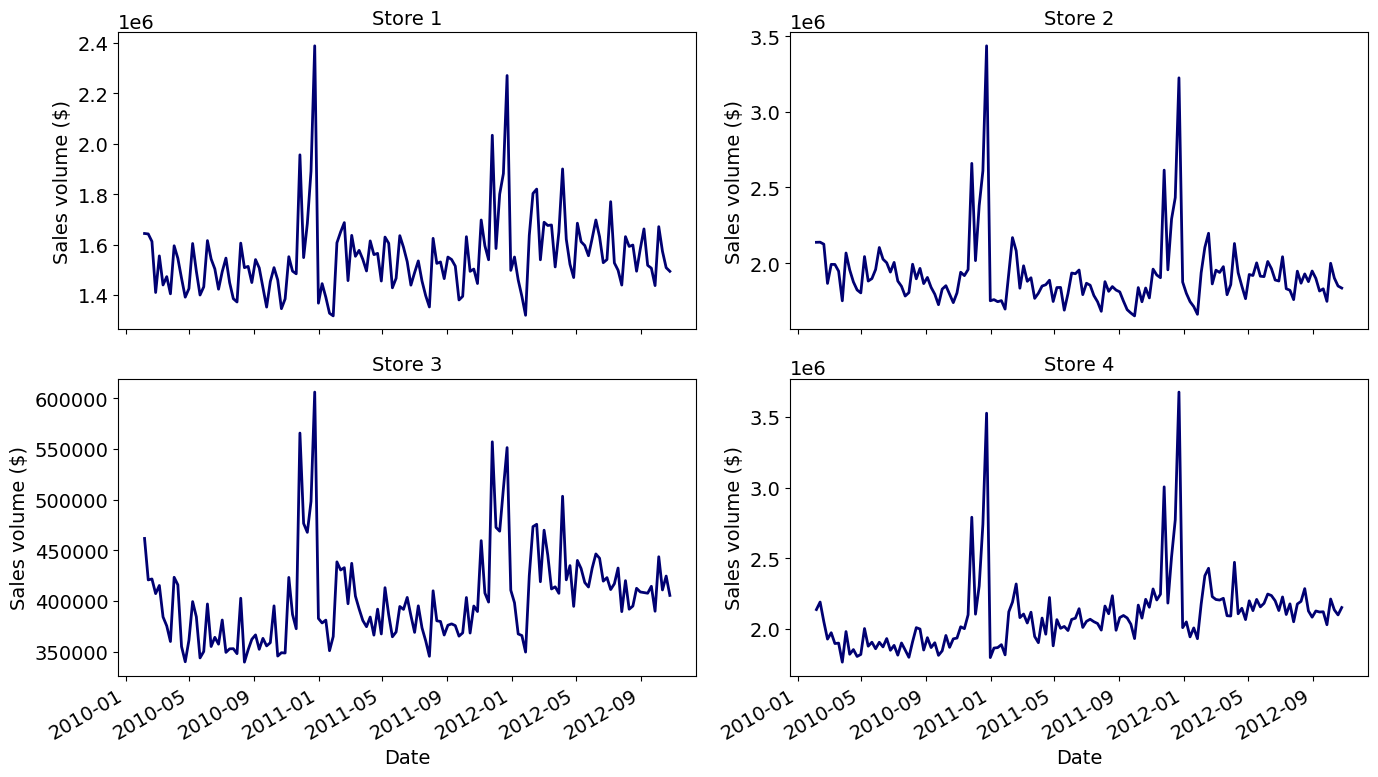

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,8))

for i, ax in enumerate(axes.flatten()):
    store_id = i+1
    data = df.query("Store == @store_id")
    
    ax.plot(data['Date'], data['Weekly_Sales'])
    ax.set_title(f"Store {store_id}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales volume ($)')

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH05_F08_peixeiro2.png", dpi=300)
plt.savefig('figures/CH05_F08_peixeiro2.pdf', format='pdf', bbox_inches='tight')

In [5]:
context = [torch.tensor(df.query("Store == @i")['Weekly_Sales'].to_numpy()) for i in range(1, 5)]

In [6]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference, "mps" for Apple Silicon, "cuda" for GPU supporting CUDA
    torch_dtype=torch.bfloat16,
)

predictions = pipeline.predict(
    context=context,
    prediction_length=8,
    num_samples=20,
)

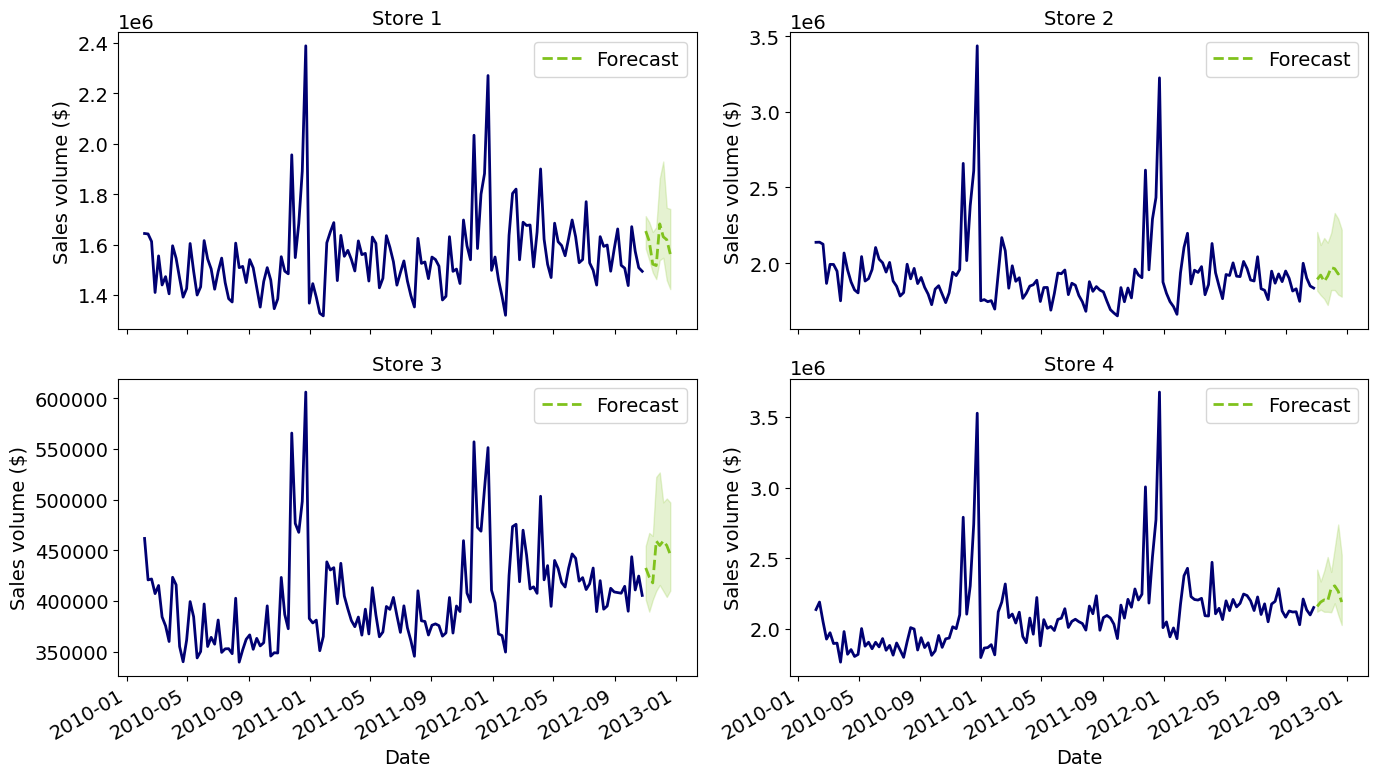

In [7]:
start_date = pd.to_datetime('2012-10-26')
forecast_dates =  [start_date + pd.DateOffset(weeks=i) for i in range(1, 9)]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,8))

for i, ax in enumerate(axes.flatten()):
    store_id = i+1
    data = df.query("Store == @store_id")
    low, median, high = np.quantile(predictions[i].numpy(), [0.1, 0.5, 0.9], axis=0)
    
    ax.plot(data['Date'], data['Weekly_Sales'])
    ax.plot(forecast_dates, median, ls='--', color='#80c21d', label='Forecast')
    ax.fill_between(forecast_dates, low, high, color="#80c21d", alpha=0.2)
    
    ax.set_title(f"Store {store_id}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales volume ($)')
    ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH05_F10_peixeiro2.png", dpi=300)
plt.savefig('figures/CH05_F10_peixeiro2.pdf', format='pdf', bbox_inches='tight')

## Cross-validation with Chronos

In [8]:
def cross_validation_chronos(df, h, n_windows, target_col):

    lows = []
    medians = []
    highs = []
    
    for i in range(n_windows, 0, -1):
        context = torch.tensor(df[target_col][:-(h * i)])

        predictions = pipeline.predict(
            context=context,
            prediction_length=h,
            num_samples=20,
        )
    
        low, median, high = np.quantile(predictions[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    
        lows.extend(low)
        medians.extend(median)
        highs.extend(high)

    return lows, medians, highs
            

In [9]:
df = df.query('Store == 1')

lows, medians, highs = cross_validation_chronos(df, 
                                                h=8, 
                                                n_windows=4, 
                                                target_col='Weekly_Sales')

In [10]:
test_df = df[['Store', 'Date', "Weekly_Sales"]][-32:]

test_df['low'] = lows
test_df['median'] = medians
test_df['high'] = highs

test_df.head()

,Store,Date,Weekly_Sales,low,median,high
111,1,2012-03-23,1511068.07,1.517926e+06,1.622297e+06,1.725534e+06
112,1,2012-03-30,1649604.63,1.449857e+06,1.576918e+06,1.684693e+06
113,1,2012-04-06,1899676.88,1.505446e+06,1.656331e+06,1.760704e+06
114,1,2012-04-13,1621031.70,1.554230e+06,1.610952e+06,1.690366e+06
115,1,2012-04-20,1521577.87,1.504311e+06,1.599608e+06,1.726669e+06


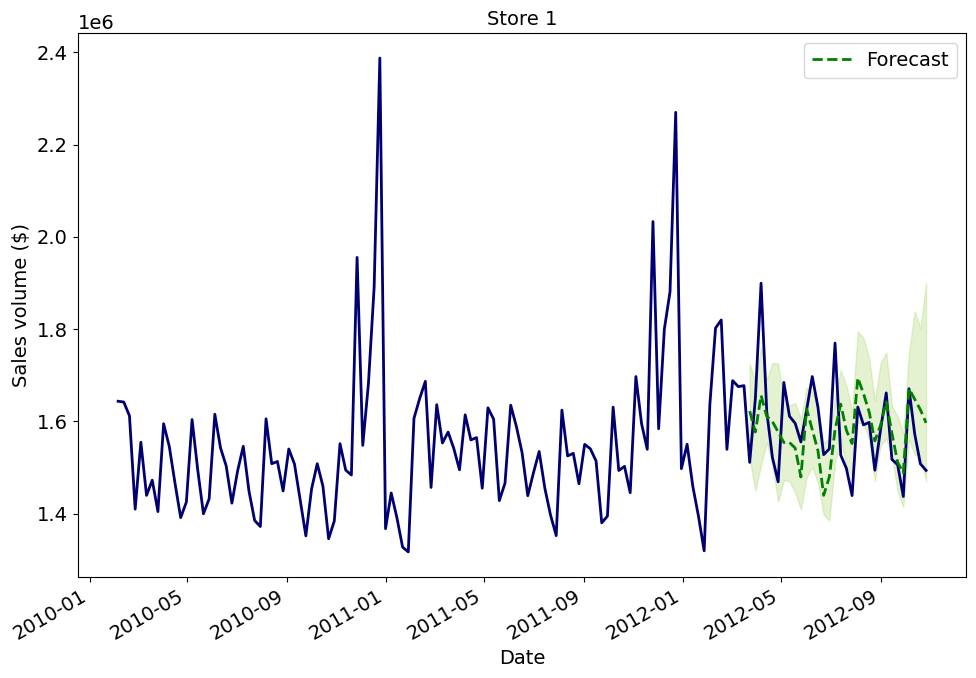

In [11]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df['Date'], df['Weekly_Sales'])
ax.plot(test_df['Date'], test_df['median'], ls='--', color='green', label='Forecast')
ax.fill_between(test_df['Date'], test_df['low'], test_df['high'], color="#80c21d", alpha=0.2)

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH05_F11_peixeiro2.png", dpi=300)
plt.savefig('figures/CH05_F11_peixeiro2.pdf', format='pdf', bbox_inches='tight')

In [12]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=['median'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,median
0,1,mae,76592.973475
1,1,smape,0.024065


## Finetuned Chronos

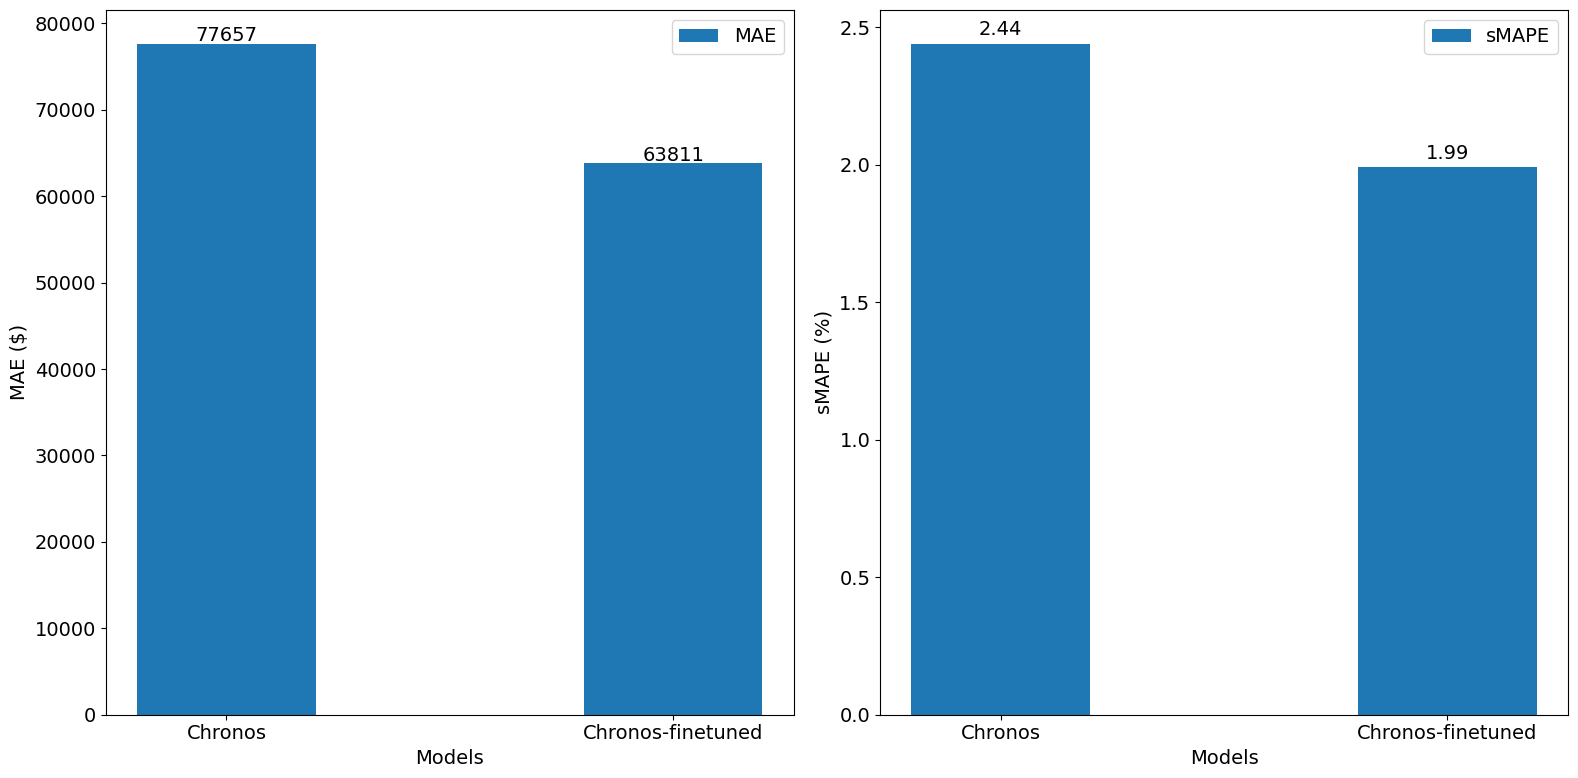

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Chronos', 'Chronos-finetuned']
y_mae = [77657, 63811]
y_smape = [2.44, 1.99]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend()

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/Ch05_codefig04.png", dpi=300)

## Anomaly detection

In [16]:
df = pd.read_csv('../data/nyc_taxi_anomaly_daily.csv', parse_dates=['timestamp'])
df.head()

,timestamp,value,is_anomaly
0,2014-07-01,745967,0
1,2014-07-02,733640,0
2,2014-07-03,710142,0
3,2014-07-04,552565,0
4,2014-07-05,555470,0


In [17]:
def anomaly_detection_chronos(df, h, n_windows, value_col, confidence=0.99):

    lows = []
    medians = []
    highs = []

    low_conf = 1 - confidence
    
    for i in range(n_windows, 0, -1):
        context = torch.tensor(df[value_col][:-(h * i)])

        predictions = pipeline.predict(
            context=context,
            prediction_length=h,
            num_samples=20,
            limit_prediction_length=False
        )
    
        low, median, high = np.quantile(predictions[0].numpy(), [low_conf, 0.5, confidence], axis=0)
    
        lows.extend(low)
        medians.extend(median)
        highs.extend(high)

    df_test = df[-(n_windows*h):]
    
    df_test['low'] = lows
    df_test['median'] = medians
    df_test['high'] = highs

    df_test['anomaly'] = ((df_test[value_col] < df_test['low']) | (df_test[value_col] > df_test['high'])).astype(int)

    return df_test

In [18]:
anomaly_df = anomaly_detection_chronos(df, 
                                       h=23, 
                                       n_windows=8, 
                                       value_col='value', 
                                       confidence=0.99)
anomaly_df

,timestamp,value,is_anomaly,low,median,high,anomaly
31,2014-08-01,769160,0,697237.915000,770370.50000,816856.831250,0
32,2014-08-02,781616,0,673124.238750,770370.50000,814851.761250,0
33,2014-08-03,699449,0,668322.888750,770370.50000,835957.761250,0
34,2014-08-04,662215,0,623630.838750,757179.43750,849307.041250,0
35,2014-08-05,710728,0,611547.674375,743988.31250,810841.609375,0
...,...,...,...,...,...,...,...
210,2015-01-27,232058,1,414322.915938,628410.15625,796128.840000,1
211,2015-01-28,621483,0,478768.621563,647128.56250,842497.533125,0
212,2015-01-29,704935,0,503209.667500,657824.87500,812922.125000,0
213,2015-01-30,800478,0,511606.006250,673869.40625,852659.041875,0


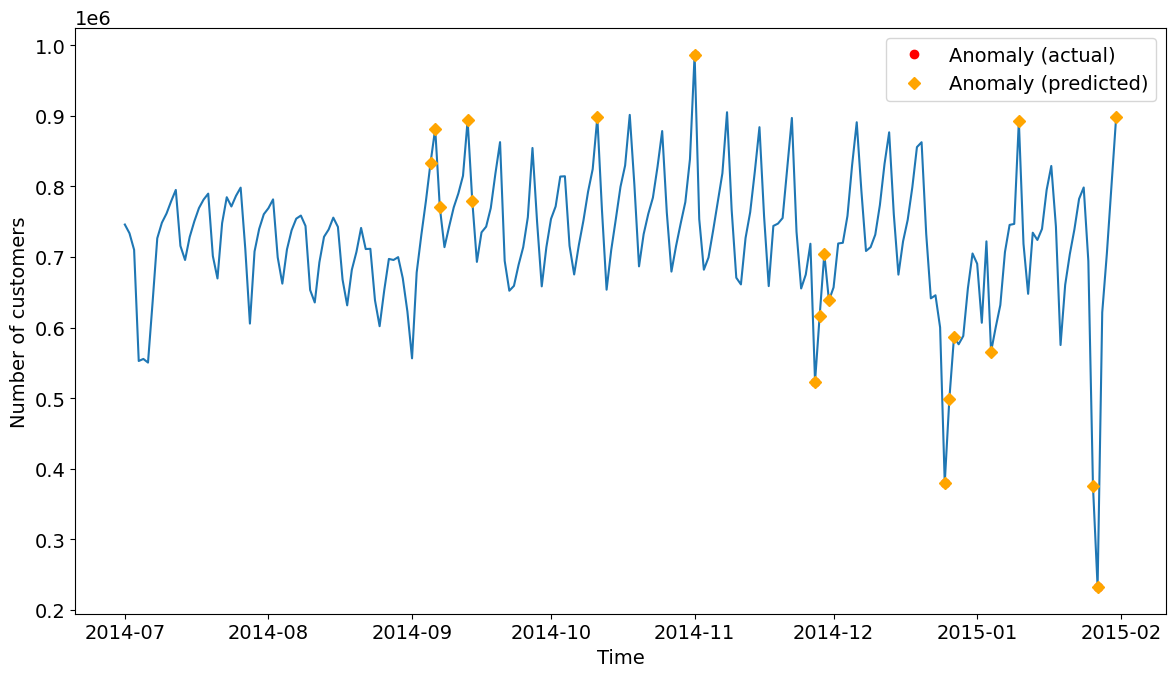

In [19]:
actual_anomaly_df = df.loc[df['is_anomaly'] == 1]
pred_anomaly_df = anomaly_df.loc[anomaly_df['anomaly'] == 1] 

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(df['timestamp'], df['value'])
ax.plot(actual_anomaly_df['timestamp'], actual_anomaly_df['value'], 'o', color='red', label='Anomaly (actual)')
ax.plot(pred_anomaly_df['timestamp'], pred_anomaly_df['value'], 'D', color='orange', label='Anomaly (predicted)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("figures/CH05_codefig05.png", dpi=300)

In [20]:
def evaluate_anomaly_detection(df, preds_col, actual_col):
    tp = ((df[preds_col] == 1) & (df[actual_col] == 1)).sum()
    
    tn = ((df[preds_col] == 0) & (df[actual_col] == 0)).sum()
    
    fp = ((df[preds_col] == 1) & (df[actual_col] == 0)).sum()
    
    fn = ((df[preds_col] == 0) & (df[actual_col] == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score

In [21]:
precision, recall, f1_score = evaluate_anomaly_detection(anomaly_df[-182:], 'anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

Precision: 0.21
Recall: 1.0
F1-Score: 0.35


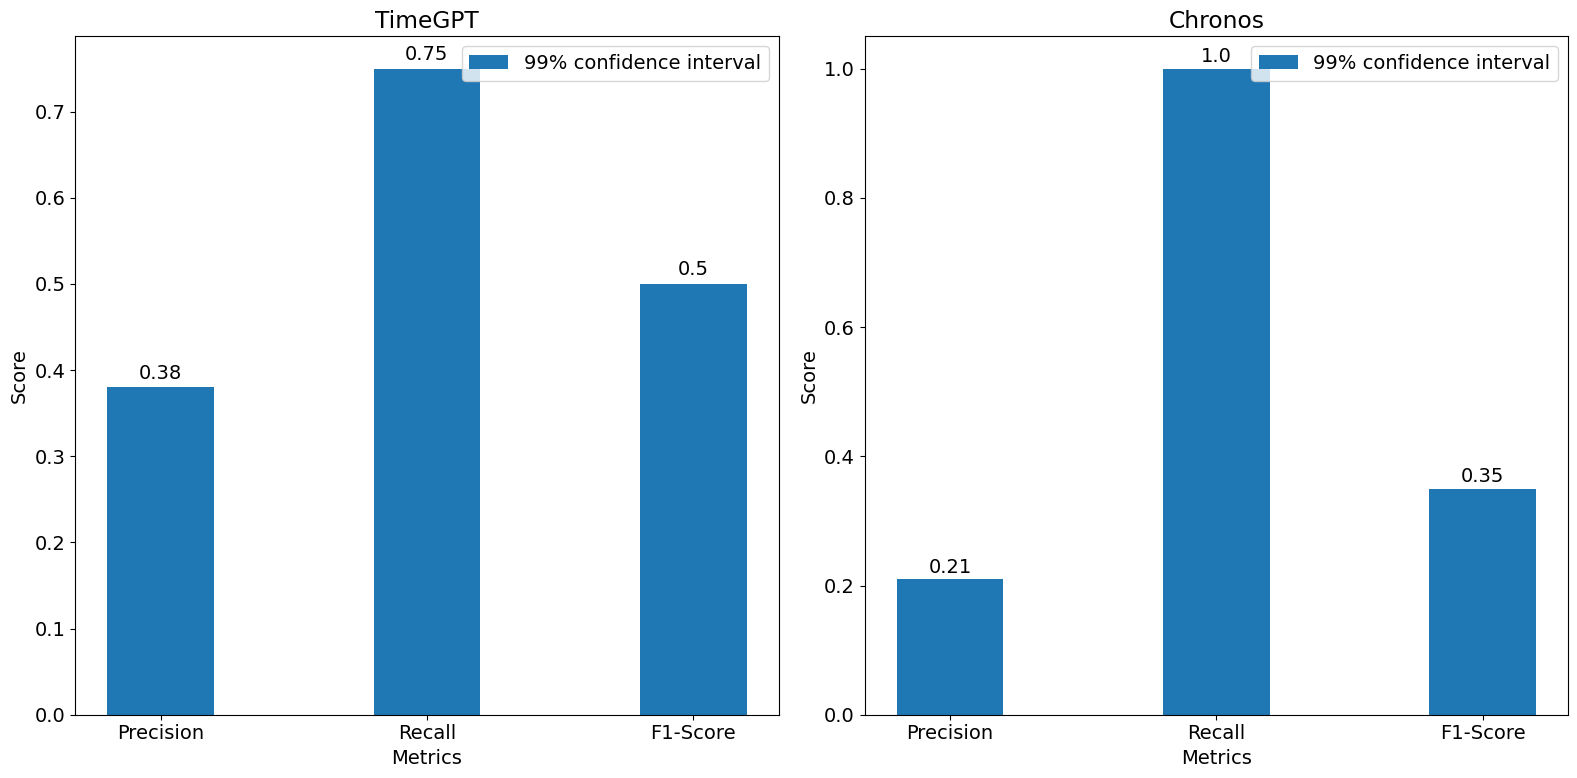

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Precision', 'Recall', 'F1-Score']
y_99_timegpt = [0.38, 0.75, 0.50]
y_99_chronos = [round(precision, 2), round(recall,2), round(f1_score,2)]

ax1.bar(x, y_99_timegpt, width=0.4, label='99% confidence interval')
ax1.set_title('TimeGPT')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.legend()

for i, v in enumerate(y_99_timegpt):
    ax1.text(x=i, y=v+0.01, s=str(v), ha='center')

ax2.bar(x, y_99_chronos, width=0.4, label='99% confidence interval')
ax2.set_title('Chronos')
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.legend()

for i, v in enumerate(y_99_chronos):
    ax2.text(x=i, y=v+.01, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH05_codefig06.png", dpi=300)

### Extras

#### Tokenization

In [ ]:
chronos_df = df[['Store', 'Date', 'Weekly_Sales']]

In [70]:
chronos_df = chronos_df.query('Store == 1')
chronos_df

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68
...,...,...,...
138,1,2012-09-28,1437059.26
139,1,2012-10-05,1670785.97
140,1,2012-10-12,1573072.81
141,1,2012-10-19,1508068.77


In [35]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))

    return x/mean

In [72]:
y = chronos_df['Weekly_Sales'].values
y_scaled = mean_scaling(y)

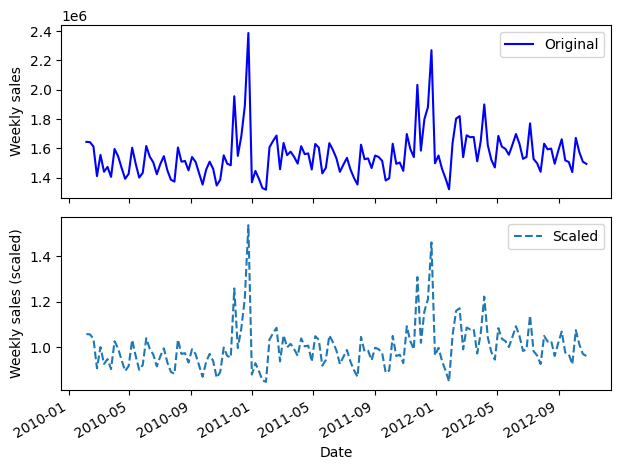

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(chronos_df['Date'], y, color='blue', label='Original')
ax1.set_ylabel('Weekly sales')
ax1.legend()

ax2.plot(chronos_df['Date'], y_scaled, ls='--', label='Scaled')
ax2.set_ylabel('Weekly sales (scaled)')
ax2.set_xlabel('Date')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/Ch05_codefig07.png", dpi=300)

In [73]:
def uniform_binning(df, column, n_bins):
    
    bin_edges = pd.cut(df[column], bins=n_bins, labels=False)
    df[f'{column}_{n_bins}'] = bin_edges

    return df

In [74]:
chronos_df['sales_scaled'] = y_scaled

chronos_df = uniform_binning(chronos_df, 'sales_scaled', 100)
chronos_df

,Store,Date,Weekly_Sales,sales_scaled,sales_scaled_100
0,1,2010-02-05,1643690.90,1.056856,30
1,1,2010-02-12,1641957.44,1.055742,30
2,1,2010-02-19,1611968.17,1.036459,27
3,1,2010-02-26,1409727.59,0.906423,8
4,1,2010-03-05,1554806.68,0.999706,22
...,...,...,...,...,...
138,1,2012-09-28,1437059.26,0.923997,11
139,1,2012-10-05,1670785.97,1.074278,33
140,1,2012-10-12,1573072.81,1.011450,23
141,1,2012-10-19,1508068.77,0.969654,17


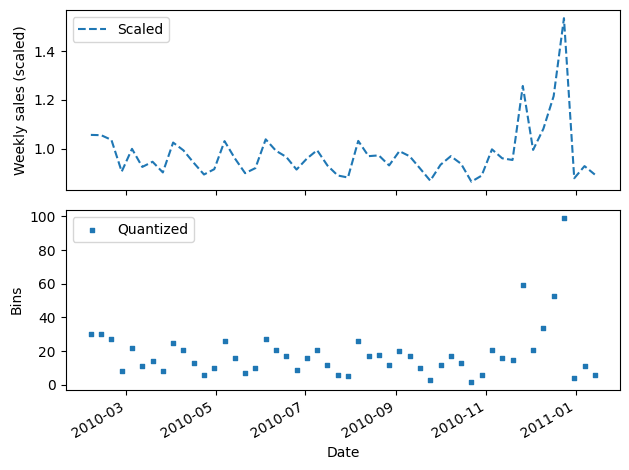

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(chronos_df['Date'][:50], y_scaled[:50], ls='--', label='Scaled')
ax1.set_ylabel('Weekly sales (scaled)')
ax1.legend()

ax2.scatter(chronos_df['Date'][:50], chronos_df['sales_scaled_100'][:50], marker='s', s=5, label='Quantized')
ax2.set_ylabel('Bins')
ax2.set_xlabel('Date')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/Ch05_codefig08.png", dpi=300)

In [79]:
chronos_df = uniform_binning(chronos_df, 'sales_scaled', 5)
chronos_df

,Store,Date,Weekly_Sales,sales_scaled,sales_scaled_100,sales_scaled_10,sales_scaled_5
0,1,2010-02-05,1643690.90,1.056856,30,3,1
1,1,2010-02-12,1641957.44,1.055742,30,3,1
2,1,2010-02-19,1611968.17,1.036459,27,2,1
3,1,2010-02-26,1409727.59,0.906423,8,0,0
4,1,2010-03-05,1554806.68,0.999706,22,2,1
...,...,...,...,...,...,...,...
138,1,2012-09-28,1437059.26,0.923997,11,1,0
139,1,2012-10-05,1670785.97,1.074278,33,3,1
140,1,2012-10-12,1573072.81,1.011450,23,2,1
141,1,2012-10-19,1508068.77,0.969654,17,1,0


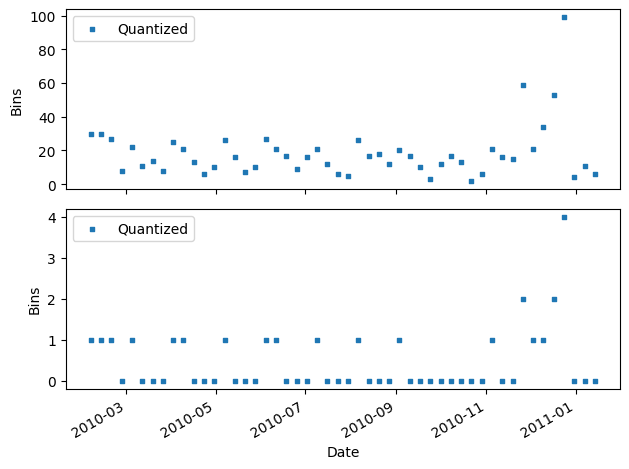

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.scatter(binned_df['Date'][:50], chronos_df['sales_scaled_100'][:50], marker='s', s=5, label='Quantized')
ax1.set_ylabel('Bins')
ax1.set_xlabel('Date')
ax1.legend()

ax2.scatter(chronos_df['Date'][:50], chronos_df['sales_scaled_5'][:50], marker='s', s=5, label='Quantized')
ax2.set_ylabel('Bins')
ax2.set_xlabel('Date')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/Ch05_codefig09.png", dpi=300)

#### Data augmentation

In [49]:
df = df.iloc[:, :3]
traffic_df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/daily_traffic.csv", parse_dates=['date_time'])

sales_data = df.query("Store == 1").reset_index(drop=True)

n = min(len(sales_data), len(traffic_df))
sales_data = sales_data[:n]
traffic_data = traffic_df[:n]

def tsmixup(data1, data2, lambda_val=0.5):
    # lambda_val = np.random.beta(alpha, alpha)
    mixed_data = lambda_val * data1 + (1-lambda_val) * data2
    return mixed_data

mixed_series = tsmixup(
    mean_scaling(sales_data['Weekly_Sales']), 
    mean_scaling(traffic_data['traffic_volume']))

mixed_data = sales_data.copy()
mixed_data['mixed'] = mixed_series

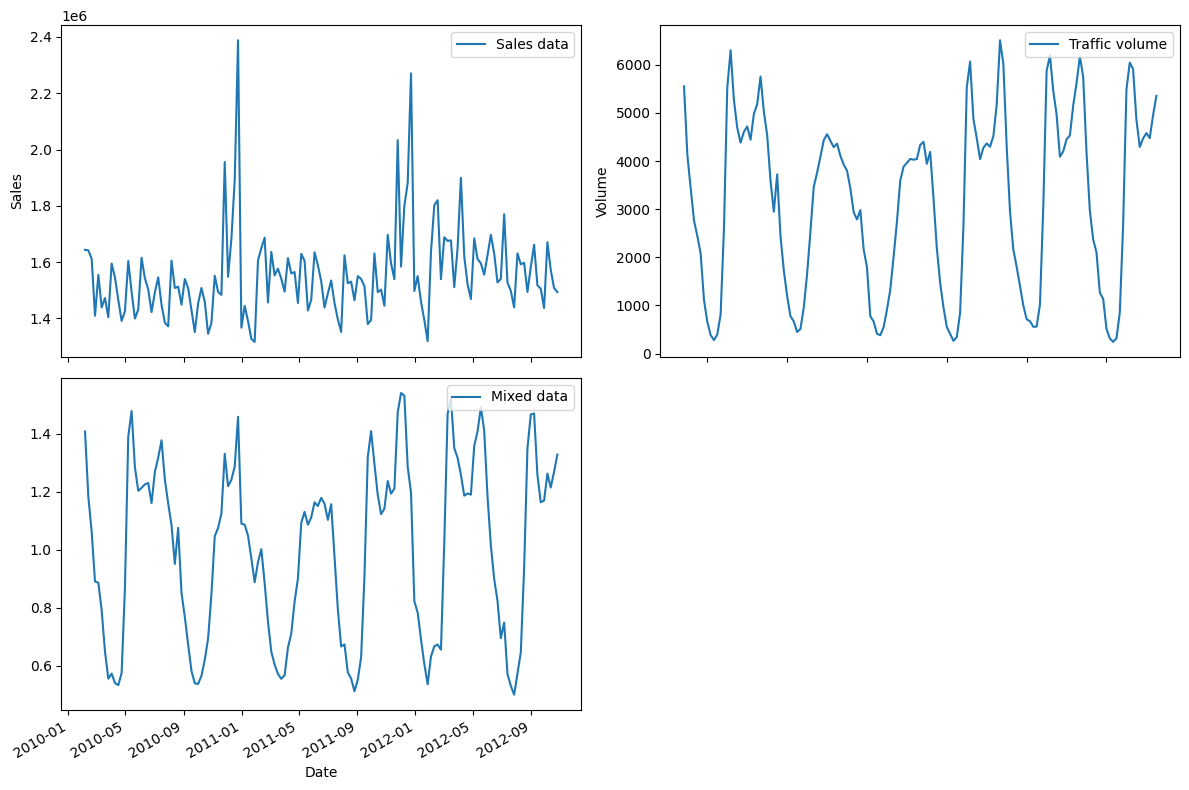

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].plot(sales_data['Date'], sales_data['Weekly_Sales'], label='Sales data')
axs[0,0].set_xlabel('Date')
axs[0,0].set_ylabel('Sales')
axs[0,0].legend()

axs[0,1].plot(traffic_data['date_time'], traffic_data['traffic_volume'], label='Traffic volume')
axs[0,1].set_xlabel('Date')
axs[0,1].set_ylabel('Volume')
axs[0,1].legend(loc=1)

axs[1,0].plot(mixed_data['Date'], mixed_data['mixed'], label='Mixed data')
axs[1,0].set_xlabel('Date')
axs[1,0].legend(loc=1)

fig.delaxes(axs[1,1])
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH05_codefig10.png", dpi=300)
